In [1]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99%|██████████████████████████████████████▋| 2.28G/2.29G [00:10<00:00, 252MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:10<00:00, 236MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [6]:
import os
import shutil

def delete_kaggle_directory(directory_path):
    """
    Deletes a directory and all its contents.

    Args:
        directory_path (str): Path to the directory to delete.
    """
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_path}' has been deleted.")
    else:
        print(f"Directory '{directory_path}' does not exist.")

# Example usage
delete_kaggle_directory("/kaggle/working/chest_xray/__MACOSX") 
delete_kaggle_directory("/kaggle/working/chest_xray/chest_xray")


Directory '/kaggle/working/chest_xray/__MACOSX' has been deleted.
Directory '/kaggle/working/chest_xray/chest_xray' has been deleted.


In [ ]:
#!pip install torch==1.0.1 torchvision==0.2.2

After setting up the Colab notebook on Google free GPU, now we can get started with our project. First, we import all the required package:

In [34]:
###import packages for project

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
import cv2
import torch.nn.functional as F
import random


The more data, the better the model will learn. Hence, apply some data augmentation to generate different variations of the original data to increase the sample size for training, validation and testing process. This augmentation can be performed by defining a set of transforming functions in the torchvision module. The detailed codes are as following:

In [8]:
## data augmentation with torchvision.transforms

train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

valid_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

X_train = torchvision.datasets.ImageFolder(root='/kaggle/working/chest_xray/train', transform=train_transforms)
X_test = torchvision.datasets.ImageFolder(root='/kaggle/working/chest_xray/test', transform=test_transforms)
X_valid = torchvision.datasets.ImageFolder(root='/kaggle/working/chest_xray/val', transform=valid_transforms)

In [9]:
from torch.utils.data import DataLoader

X_train_loader = DataLoader(X_train, batch_size=16, shuffle=True)
X_test_loader = DataLoader(X_test, batch_size=16, shuffle=True)
X_valid_loader = DataLoader(X_valid, batch_size=16, shuffle=True)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import copy

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 2),
            nn.LogSoftmax(dim=1)
        )
        self.model.fc = self.classifier

    def forward(self, x):
        return self.model(x)

    def fit(self, dataloaders, num_epochs=10):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(device)

        optimizer = optim.Adam(self.model.fc.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
        criterion = nn.NLLLoss()

        since = time.time()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print("-" * 10)

            for phase in ['train', 'test']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects / len(dataloaders[phase].dataset)

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())

            scheduler.step()

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best test Acc: {best_acc:.4f}")

        self.model.load_state_dict(best_model_wts)
        return self.model


In [12]:
# Calling the model and fit on training data:
model = Model()
model_ft = model.fit({'train': X_train_loader, 'test': X_test_loader}, 5)

Epoch 1/5
----------
train Loss: 0.2764 Acc: 0.8806
test Loss: 0.3822 Acc: 0.8269
Epoch 2/5
----------
train Loss: 0.1985 Acc: 0.9181
test Loss: 0.4018 Acc: 0.8253
Epoch 3/5
----------
train Loss: 0.2065 Acc: 0.9185
test Loss: 0.3790 Acc: 0.8317
Epoch 4/5
----------
train Loss: 0.1769 Acc: 0.9275
test Loss: 0.4160 Acc: 0.8205
Epoch 5/5
----------
train Loss: 0.1550 Acc: 0.9390
test Loss: 0.4149 Acc: 0.8269
Training complete in 17m 56s
Best test Acc: 0.8317


In [13]:
# Save the trained model
torch.save(model.state_dict(), "best_covid_model.pth")

When we want to load this trained weights back to the model for prediction on new data, we just need to follow these lines of code:

In [14]:
# Loading the saved model for prediction
state_dict = torch.load("best_covid_model.pth")
model.load_state_dict(state_dict, strict=False)
model_ft = model.model
model_ft = model_ft.eval()

<ipython-input-14-a128b47be39e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_covid_model.pth")


In [15]:
import PIL
import torchvision.transforms as transforms

loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [16]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            # Move inputs and model to the same device (GPU in this case)
            x = x.to(device)
            model = model.to(device)
            scores = model(x) # No need to move scores to device, it's already there
            _, predictions = scores.max(1)
            num_correct += (predictions == y.to(device)).sum() # Move y to device too
            num_samples += predictions.size(0)
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    model.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
check_accuracy(X_train_loader, model_ft)

Got 4954 / 5216 with accuracy 94.98


In [17]:
check_accuracy(X_test_loader, model)

Got 519 / 624 with accuracy 83.17


For activation map, we can use the register_forward_hook module to obtain activation of the last convolutional layer as described above, we use the register_forward_hook module. The code is as following:

In [100]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3))

        # Weight the activations
        cam = torch.zeros(self.activations.shape[2:], device=self.activations.device)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]

        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)

        return cam.detach()

def visualize_cam(image, cam):
    # Convert PIL Image to numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    # Convert CAM to numpy array if it isn't already
    if torch.is_tensor(cam):
        cam = cam.cpu().numpy()

    # Normalize CAM to 0-1 range if needed
    if cam.max() > 1:
        cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Ensure cam is the same size as the input image
    cam_resized = cv2.resize(cam, (image_np.shape[1], image_np.shape[0]))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Convert RGB to BGR if necessary (OpenCV uses BGR)
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Ensure both images have the same number of channels
    if len(image_np.shape) != len(heatmap.shape):
        if len(image_np.shape) == 2:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    # Now combine them
    result = cv2.addWeighted(image_np, 0.7, heatmap, 0.7, 5)

    return result

In [88]:
test_dir='/kaggle/working/chest_xray/test/NORMAL'
from skimage.io import imread
from PIL import Image
import glob
image_list = []
for filename in glob.glob(test_dir+'/*.jpeg'):
    #im=Image.open(filename)
    image_list.append(filename)

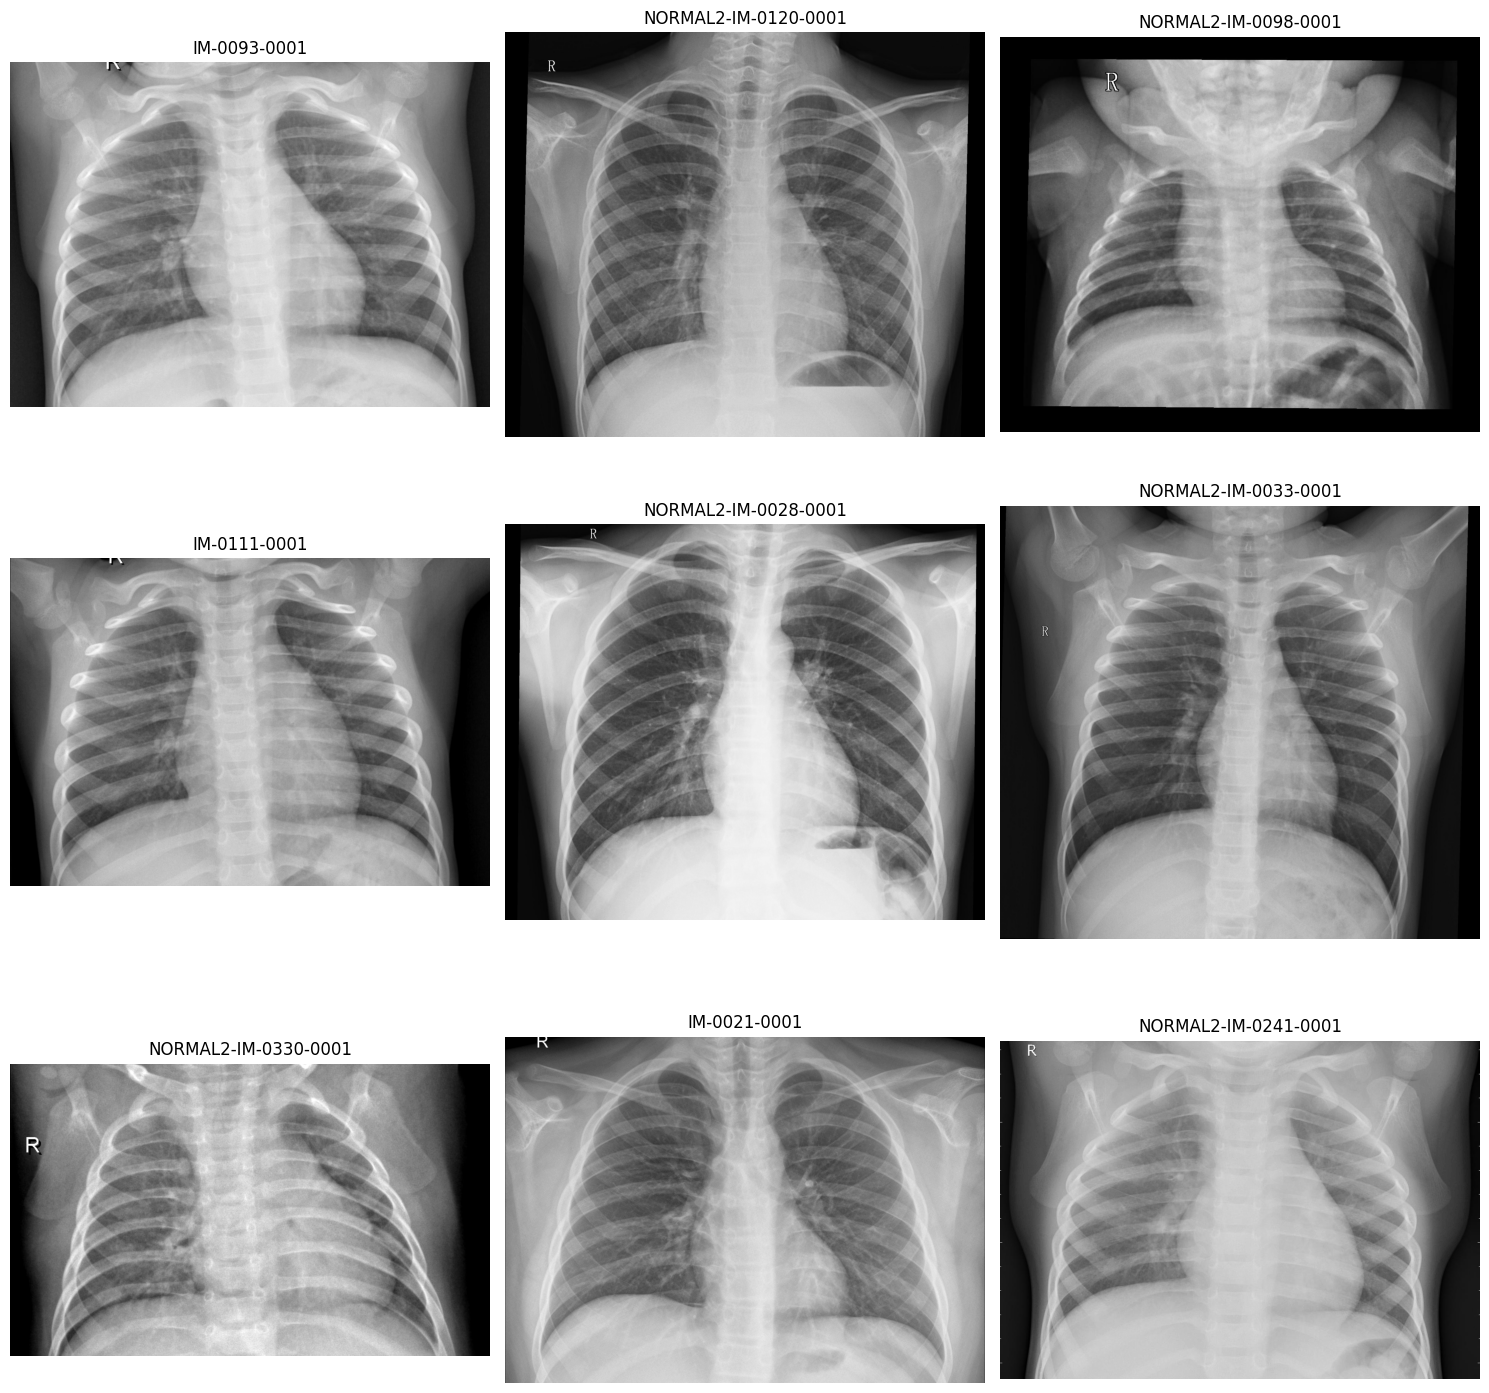

In [90]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math

def plot_input(image_list):
    num_images = len(image_list)
    grid_size = math.ceil(math.sqrt(num_images))  # Determine grid size dynamically
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))  # Adjust figure size
    ax = ax.flatten()  # Flatten the axes array for easy indexing

    for i in range(len(image_list)):
        img = imread(image_list[i])
        name = image_list[i].split("/")[-1].split(".")[0]
        ax[i].imshow(img, cmap='gray')  # Show the image
        ax[i].set_title(name, fontsize=12)  # Set the title for each image
        ax[i].axis('off')  # Hide axes for a cleaner look

    # Hide unused subplots (if any)
    for i in range(len(image_list), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_input(image_list[:9])


Now, let's load the testing data folder and use this newly defined predict_img function to visualize all the testing images (with both prediction class and Activation map). The snipet of that code is as following:

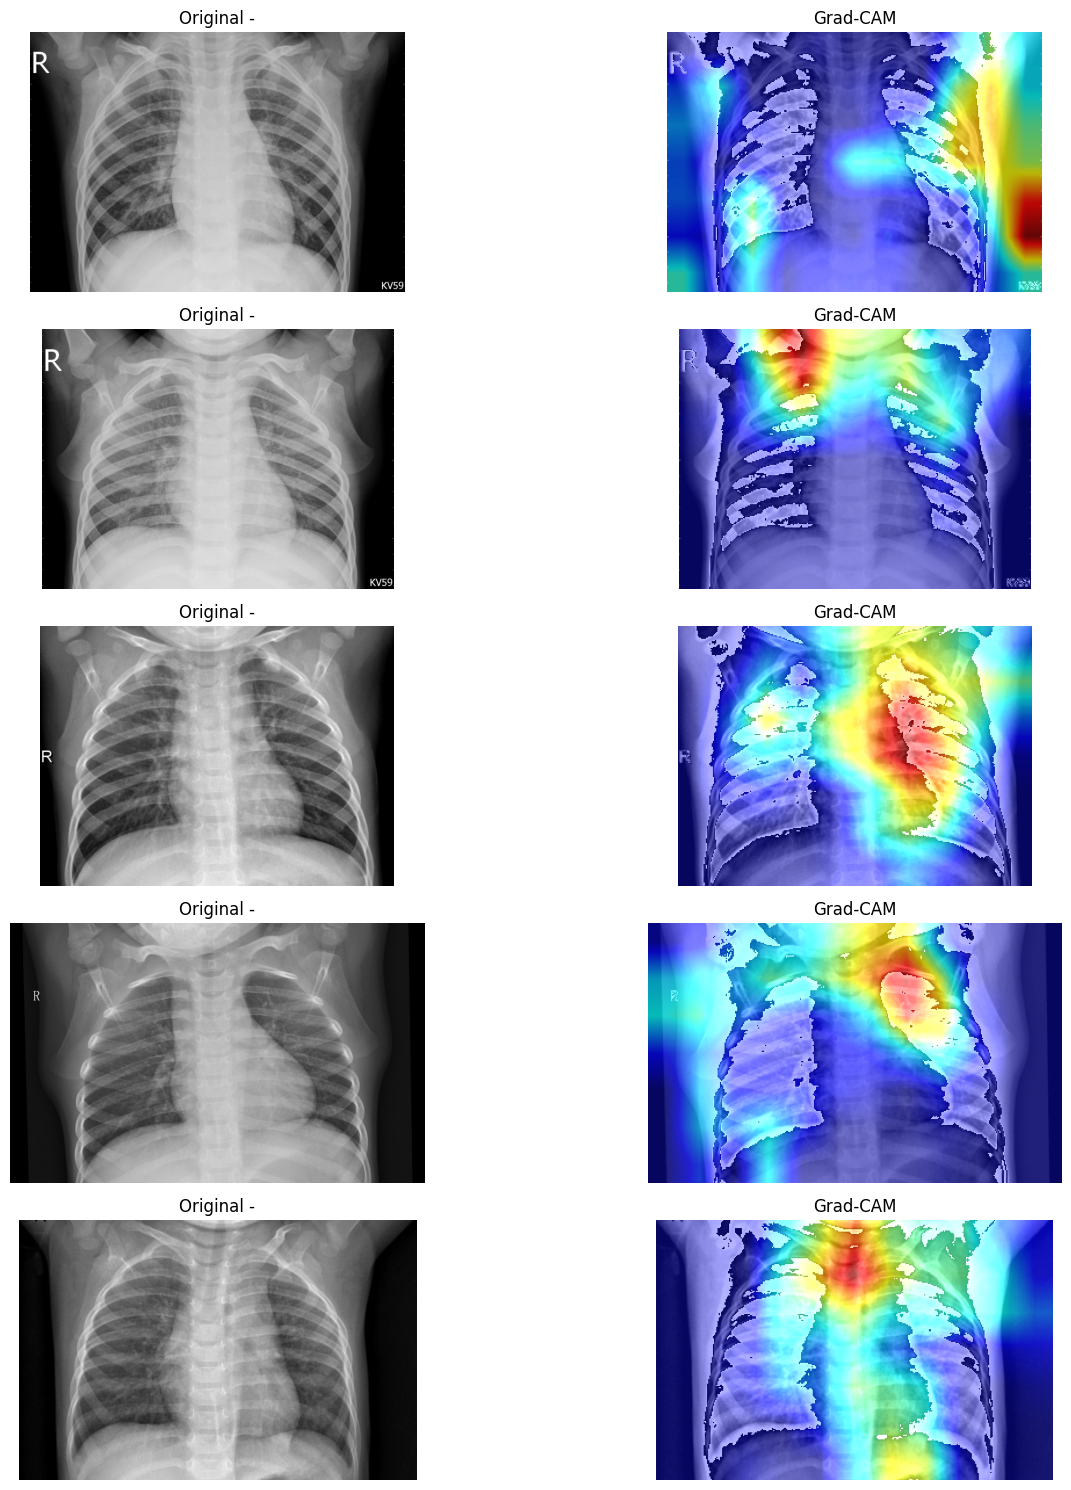

In [101]:
import random

plt.figure(figsize=(15, 15))
num_samples = 5
random_img_paths = random.sample(image_list, num_samples)

for idx, path in enumerate(random_img_paths):
    # Load and preprocess image
    pil_image = Image.open(path).convert('RGB')


    # Define transforms

    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),  
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ])

    # Transform and add batch dimension

    input_tensor = transform(pil_image).unsqueeze(0)

    # Move everything to GPU if available

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    target_layer = model.model.layer4[2].conv3
    grad_cam = GradCAM(model, target_layer)
    input_tensor = input_tensor.to(device)
    # Generate CAM
    cam = grad_cam(input_tensor)
    # Visualize
    input_image = transforms.ToPILImage()(input_tensor.squeeze(0).cpu())
    result = visualize_cam(input_image, cam)

     # Plot original and Grad-CAM
    plt.subplot(num_samples, 2, 2*idx + 1)
    plt.imshow(pil_image)
    plt.title(f'Original -')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2*idx + 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()


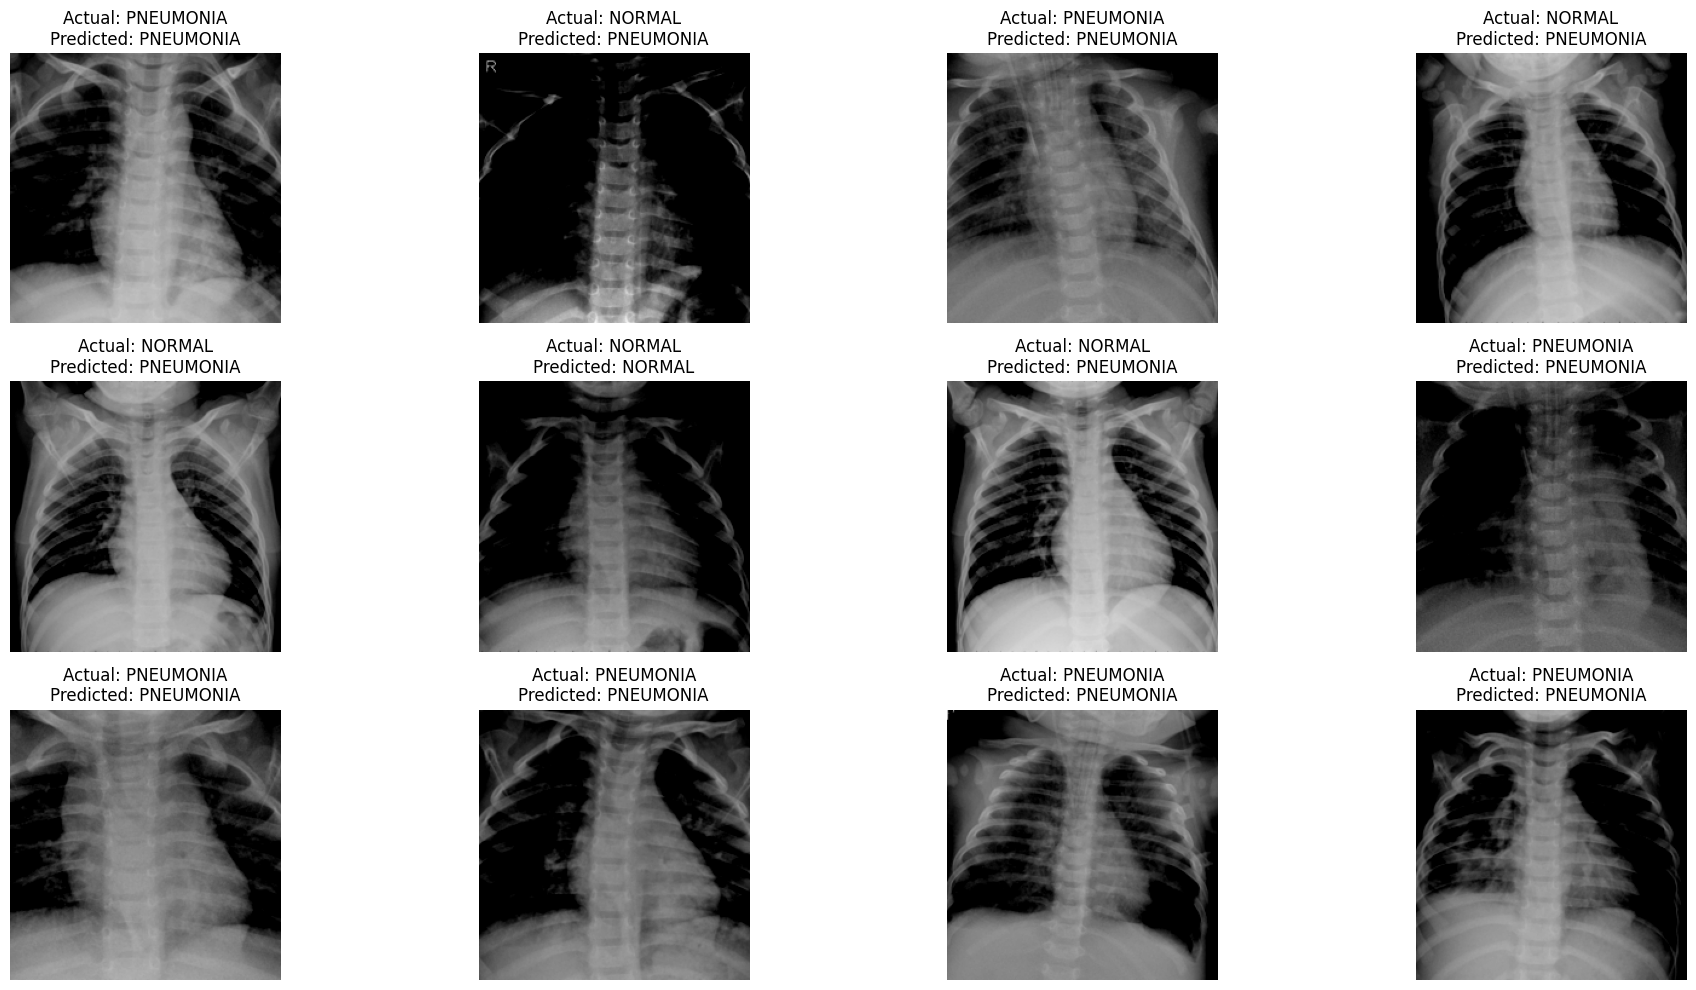

In [87]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def visualize_predictions_from_loader(val_loader, model, class_names, transform=None):
    """
    Predict and display the first 8 images from the validation loader with their predicted and actual labels.

    Args:
        val_loader (DataLoader): DataLoader for validation dataset.
        model (torch.nn.Module): Trained PyTorch model for prediction.
        class_names (list): List of class names corresponding to class indices.
        transform (callable): Transformations to apply to the images before prediction.
    """
    # Create a grid for visualization
    fig, ax = plt.subplots(3, 4, figsize=(20, 10))  # 2 rows, 4 columns
    ax = ax.flatten()

    # Ensure the model is in evaluation mode
    model.eval()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Get the first batch of data from the validation loader
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if i == 0:  # Only take the first batch
                break

        # Make sure we only use the first 8 images
        images = images[:12]
        labels = labels[:12]

        # Send the images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Make predictions
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

        # Convert tensors to CPU and numpy for display
        images = images.cpu()
        predicted_labels = predicted_labels.cpu()
        labels = labels.cpu()

        # Display the images with actual and predicted labels
        for i in range(12):
            img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
            ax[i].imshow(img)
            ax[i].axis('off')  # Hide axes for a cleaner look
            ax[i].set_title(
                f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}",
                fontsize=12
            )

    plt.tight_layout()
    plt.show()

# Example usage
class_names = ['NORMAL', 'PNEUMONIA']

# Assuming `val_loader` is your validation data loader
visualize_predictions_from_loader(X_valid_loader, model_ft, class_names)


In [62]:
import torch
from sklearn.metrics import confusion_matrix

# Initialize empty lists to store all labels
train_labels = []
test_labels = []
predicted_labels = []  # Initialize a list to store predictions

# Get labels from training data
for _, labels in X_train_loader:  # _ is used for inputs, which we don't need here
    train_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to NumPy

# Get labels and predictions from test data
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in X_test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Calculate confusion matrix using predicted labels
cm = confusion_matrix(test_labels, predicted_labels)

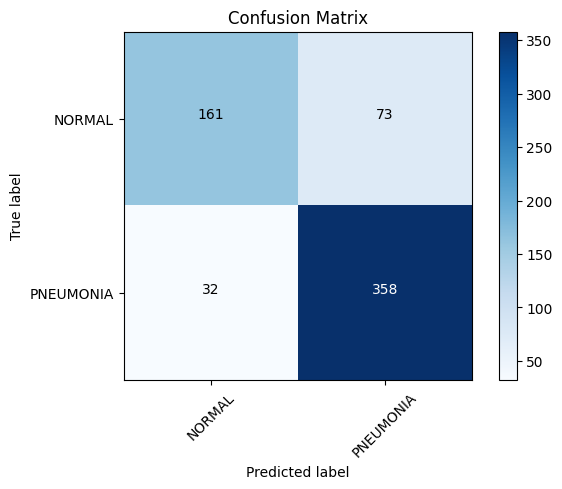

In [63]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


plot_confusion_matrix(cm, classes=['NORMAL', 'PNEUMONIA'], title='Confusion Matrix')

In [ ]:
from torchviz import make_dot
from torchsummary import summary

def archit(model):
    summary(model, (3, 224, 224))
    dummy_input = torch.randn(16, 3, 224, 224).to(device) 
    
    output = net(dummy_input).to(device)
    
    dot = make_dot(output, params=dict(net.named_parameters()))
    
    dot.render("model_architecture1", format="png") 
    dot.view()

archit(model)